In [1]:
import numpy as np
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from src.sheaf import Sheaf, Vertex, Face

# Example 1: Global section

In this example, we show how our built sheaf behaves when it has a global section, or pseudo-section if we consider the consistency structure of the sheaf, i.e. when all the assignments to the vertices and faces perfectly match together.

## Build sheaf

In [2]:
# Set vertices literals
C1 = Vertex("C1")
C2 = Vertex("C2")
S1 = Vertex("S1")
S2 = Vertex("S2")

# Define restriction map
def identity(A):
    return A

def computeAirFromVehicle(V):
    return V[0] * 0.047 + V[1] * 0.117

# Build sheaf base space
AirSheaf = Sheaf()
## Build 0-faces/vertices
AirSheaf.set_vertices([C1,C2,S1,S2])

## Build 1-faces
AirSheaf.set_higher_faces({"C": {"subfaces": {"C1": C1, "C2": C2}, "restriction_map": {"C1": computeAirFromVehicle, "C2": computeAirFromVehicle}},
                           "S": {"subfaces": {"S1": S1, "S2": S2}, "restriction_map": {"S1": identity, "S2": identity}},
                           "CS1": {"subfaces": {"C1": C1, "S1": S1}, "restriction_map": {"C1": computeAirFromVehicle, "S1": identity}},
                           "CS2": {"subfaces": {"C2": C2, "S2": S2}, "restriction_map": {"C2": computeAirFromVehicle, "S2": identity}},
                           "CS3": {"subfaces": {"C1": C1, "S2": S2}, "restriction_map": {"C1": computeAirFromVehicle, "S2": identity}},
                           "CS4": {"subfaces": {"C2": C2, "S1": S1}, "restriction_map": {"C2": computeAirFromVehicle, "S1": identity}},
                          })

C = AirSheaf.get_face("C")
S = AirSheaf.get_face("S")
CS1 = AirSheaf.get_face("CS1")
CS2 = AirSheaf.get_face("CS2")
CS3 = AirSheaf.get_face("CS3")
CS4 = AirSheaf.get_face("CS4")

## Build 2-faces
AirSheaf.set_higher_faces({"L": {"subfaces": {"C": C, "S": S}, "restriction_map": {"C": identity, "S": identity}}})
AirSheaf.set_higher_faces({"I": {"subfaces": {"CS1": CS1, "CS2": CS2, "CS3": CS3, "CS4": CS4},
                                 "restriction_map": {"CS1": identity, "CS2": identity, "CS3": identity, "CS4": identity}}})

L = AirSheaf.get_face("L")
I = AirSheaf.get_face("I")

## Build 3-faces
AirSheaf.set_higher_faces({"K": {"subfaces": {"L": L, "I": I}, "restriction_map": {"L": identity, "I": identity}}})

## Visualize the built sheaf base space

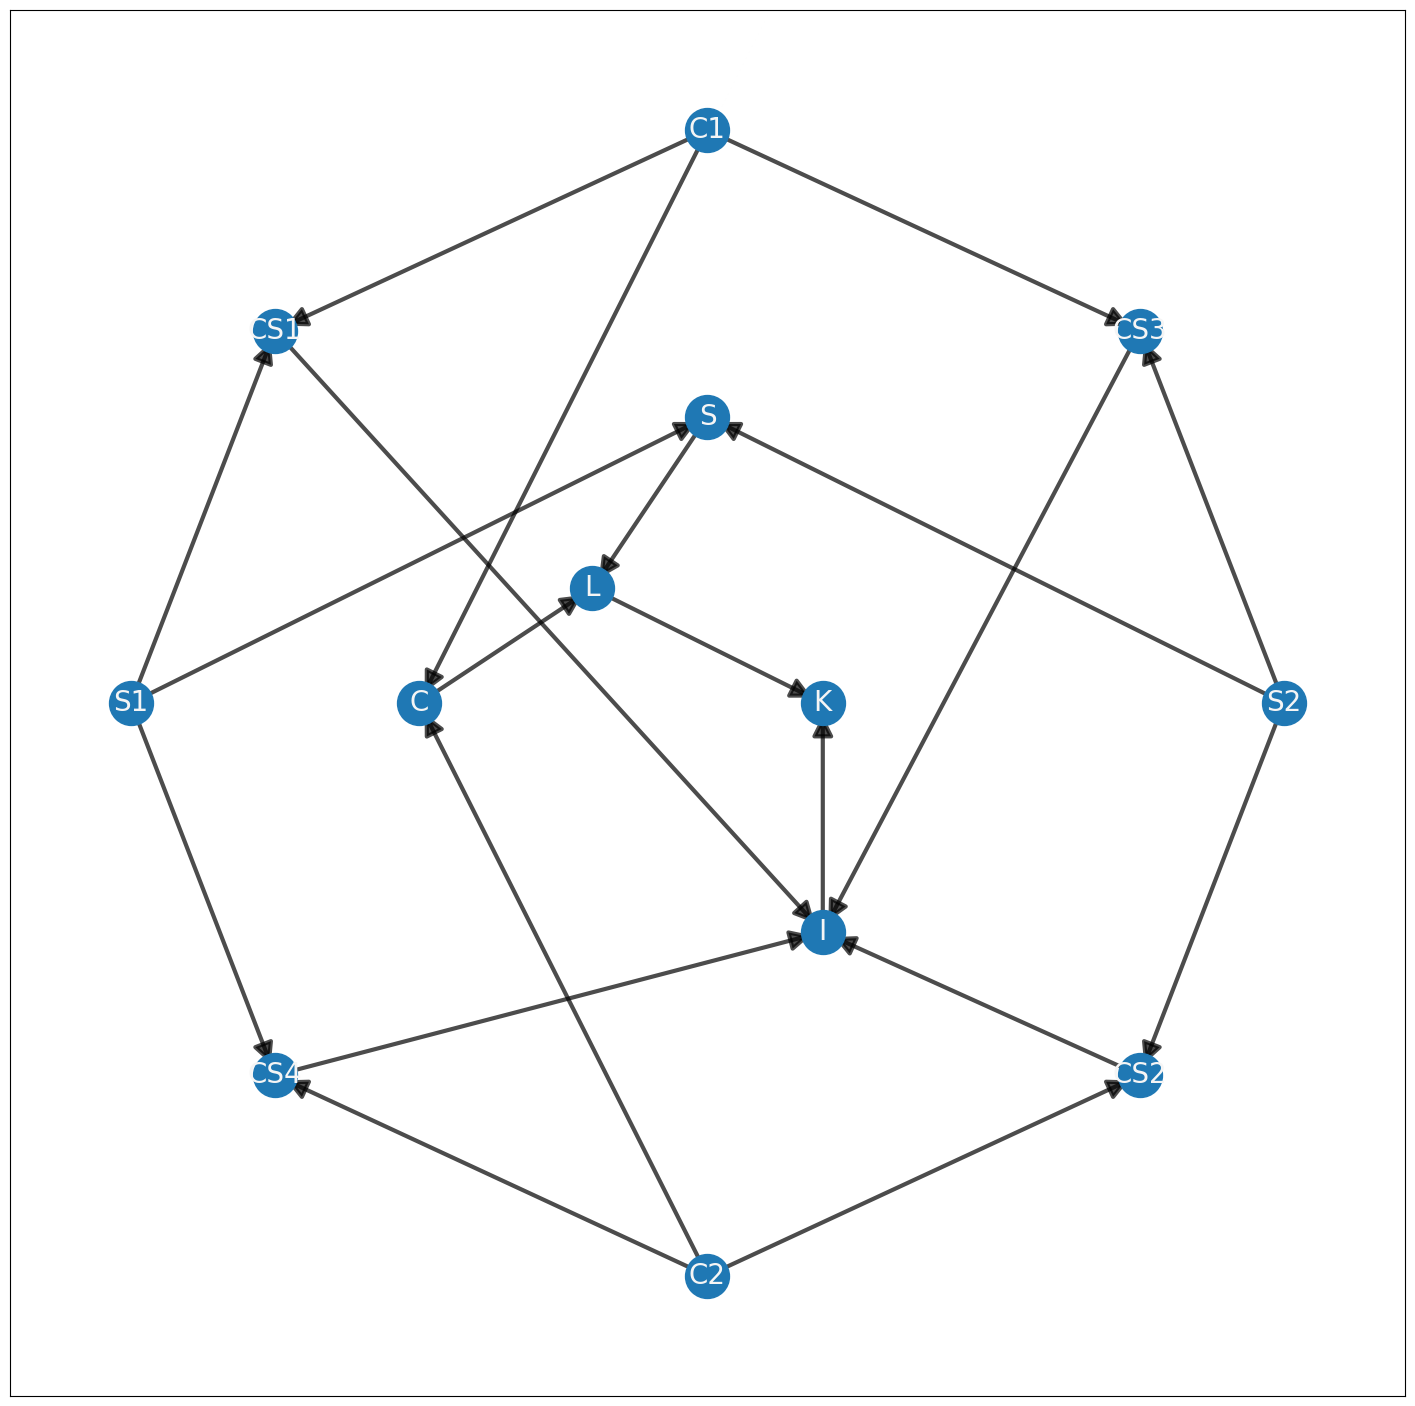

In [31]:
G = AirSheaf.visualize_sheaf_as_digraph()
pos = {
    "C2": np.array([10, 0]),
    "S1": np.array([0, 10]),
    "C1": np.array([10, 20]),
    "S2": np.array([20, 10]),
    "CS4": np.array([2.5,3.5]),
    "CS2": np.array([17.5,3.5]),
    "CS1": np.array([2.5,16.5]),
    "CS3": np.array([17.5,16.5]),
    "S": np.array([10, 15]),
    "C": np.array([5, 10]),
    "I": np.array([12, 6]),
    "L": np.array([8, 12]),
    "K": np.array([12, 10]),
}
plt.figure(figsize=(18,18))
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos, width=3, arrowsize=30, alpha=0.7)
labels = {}
labels["C1"] = "C1"
labels["C2"] = "C2"
labels["S1"] = "S1"
labels["S2"] = "S2"
labels["C"] = "C"
labels["S"] = "S"
labels["CS1"] = "CS1"
labels["CS2"] = "CS2"
labels["CS3"] = "CS3"
labels["CS4"] = "CS4"
labels["L"] = "L"
labels["I"] = "I"
labels["K"] = "K"
nx.draw_networkx_labels(G, pos, labels, font_size=20, font_color="whitesmoke")
plt.show()

The consistency thresholds in the above consistency filtration all equal 0.0, which tells us that all the faces agree with each other with a perfect consistency radius = 0. However, this hardly happens in nature because of noisy measurement of the signal. The following examples will show how good sheaf handles noisy data with the simulation signal.

In [4]:
# Do global section assignments
time = datetime.now().timestamp()
AirSheaf.propagate({"C1": [time,200,30], "C2": [time,200,30], "S1": [time,12.91], "S2": [time,12.91]})

In [5]:
# Check consistency filtration
AirSheaf.get_consistency_filtration()

{'C': 0.0,
 'S': 0.0,
 'CS1': 0.0,
 'CS2': 0.0,
 'CS3': 0.0,
 'CS4': 0.0,
 'L': 0.0,
 'I': 0.0,
 'K': 1.8553442084620055e-15}

# Example 2
To measure the simulated signal, we use four nodes, which are two cameras and two sensors that have the sampling frequency rates of once every 600s and 15s, respectively. This example examines how sheaf can provide a better data fusion than naive data aggregation, e.g. averaging.

## Data generation


### Original signal

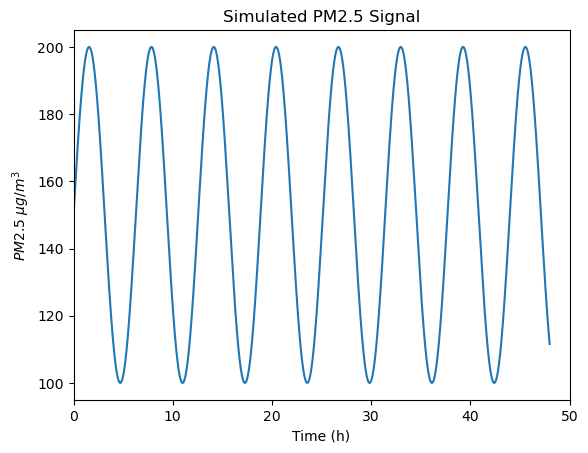

In [42]:
# This generates the original signal, which the sensors will have to measure
# plt.figure(figsize=(10,8))
x = np.arange(0,48,1/3600)
PM = np.sin(x)*50 + 150
plt.plot(x,PM)
plt.xlim(0,50)
plt.title("Simulated PM2.5 Signal")
l = r'PM2.5\ \mu g/m^3'
plt.xlabel("Time (h)")
plt.ylabel("$%s$" %l)
plt.show()

### Simulated signals for sensors

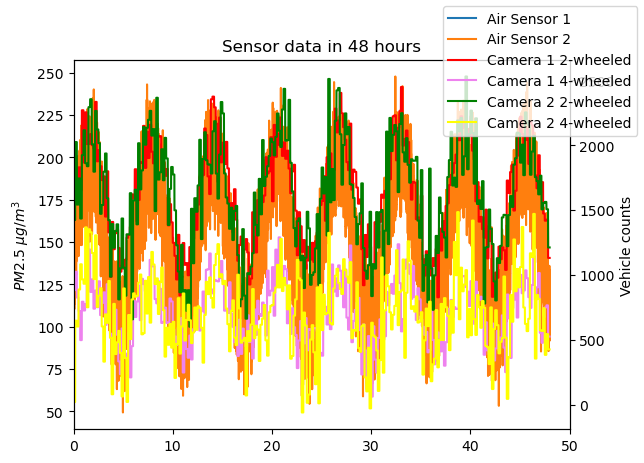

In [7]:
# Generate data for two nodes S1 and S2 of the sheaf, where S1 measures the original signal with the error of ~2.8%
# and S2 measures the original signal with the error of ~8.32%
np.random.seed(43)
noise = np.random.normal(0,1,48*3600)*5
sensor1 = PM+noise
np.random.seed(26)
noise = np.random.normal(0,1,48*3600)*15
sensor2 = PM+noise
reading_freq = 15
for i in range(len(sensor1)):
    if i % reading_freq == 0:
        temp1 = sensor1[i]
        temp2 = sensor2[i]
    else:
        sensor1[i] = temp1
        sensor2[i] = temp2

# Generate data for two nodes C1 and C2 of the sheaf, where C1 measures the original signal with the error of ~11.7%
# and S2 measures the original signal with the error of ~16.9%
np.random.seed(51)
noise1 = np.random.normal(0,1,48*3600)*150
noise2 = np.random.normal(0,1,48*3600)*150
a1 = np.sin(x)*500 + 1600 + noise1
a2 = np.sin(x)*250 + 700 + noise2
np.random.seed(13)
noise1 = np.random.normal(0,1,48*3600)*250
noise2 = np.random.normal(0,1,48*3600)*250
b1 = np.sin(x)*500 + 1600 + noise1
b2 = np.sin(x)*250 + 700 + noise2
reading_freq = 600
for i in range(len(sensor1)):
    if i % reading_freq == 0:
        temp1 = a1[i]
        temp2 = a2[i]
        temp3 = b1[i]
        temp4 = b2[i]
    else:
        a1[i] = temp1
        a2[i] = temp2
        b1[i] = temp3
        b2[i] = temp4
l = r'PM2.5\ \mu g/m^3'
fig,ax = plt.subplots()
ax.plot(x,sensor1, label="Air Sensor 1")
ax.plot(x,sensor2, label="Air Sensor 2")
ax.set_ylabel("$%s$" %l)
ax2 = ax.twinx()
ax2.plot(x,a1,c="red", label="Camera 1 2-wheeled")
ax2.plot(x,a2,c="violet", label="Camera 1 4-wheeled")
ax2.plot(x,b1,c="green", label="Camera 2 2-wheeled")
ax2.plot(x,b2,c="yellow", label="Camera 2 4-wheeled")
ax2.set_ylabel("Vehicle counts")
ax2.set_xlabel("Time(s)")
plt.xlim(0,50)
fig.legend()
plt.title("Sensor data in 48 hours")
plt.show()

### Update and propagate values over the sheaf when sensors update

In [8]:
# Set sampling interval of the camera nodes to 600s
reading_C_freq = 600
# Set sampling interval of the camera nodes to 15s
reading_S_freq = 15
summary = {}
filtration = {}
mean = {}
values = {}
for i in range(len(sensor1)):
    C = False
    S = False
    if i % reading_C_freq == 0:
        C = True
    
    if i % reading_S_freq == 0:
        S = True
        
    if C:
        AirSheaf.propagate({"C1": [i,a1[i],a2[i]], "C2": [i,b1[i],b2[i]], "S1": [i,sensor1[i]], "S2": [i,sensor2[i]]})
        summary[i] = AirSheaf.value
        mean[i] = np.mean([sensor1[i], sensor2[i], computeAirFromVehicle([a1[i],a2[i]]), computeAirFromVehicle([b1[i],b2[i]])])
        filtration[i] = AirSheaf.get_consistency_filtration()
        values[i] = {}
        for j in filtration[i]:
            values[i][j] = AirSheaf.get_face(j).value
    elif S:
        AirSheaf.propagate({"C1": [i,a1[i],a2[i]], "C2": [i,b1[i],b2[i]], "S1": [i,sensor1[i]], "S2": [i,sensor2[i]]})
        summary[i] = AirSheaf.value
        mean[i] = np.mean([sensor1[i], sensor2[i], computeAirFromVehicle([a1[i],a2[i]]), computeAirFromVehicle([b1[i],b2[i]])])
        filtration[i] = AirSheaf.get_consistency_filtration()
        values[i] = {}
        for j in filtration[i]:
            values[i][j] = AirSheaf.get_face(j).value
    elif C and S:
        AirSheaf.propagate({"C1": [i,a1[i],a2[i]], "C2": [i,b1[i],b2[i]], "S1": [i,sensor1[i]], "S2": [i,sensor2[i]]})
        summary[i] = AirSheaf.value
        mean[i] = np.mean([sensor1[i], sensor2[i], computeAirFromVehicle([a1[i],a2[i]]), computeAirFromVehicle([b1[i],b2[i]])])
        filtration[i] = AirSheaf.get_consistency_filtration()
        values[i] = {}
        for j in filtration[i]:
            values[i][j] = AirSheaf.get_face(j).value

### Calculate the average error of every individual sensors, the average value and the value determined by the sheaf 

In [9]:
error = []
error_mean = []
error_s1 = []
error_s2 = []
error_c1 = []
error_c2 = []
max_spread = 0
max_pos = 0
for i in summary:
    error.append(np.abs(summary[i] - PM[i])/PM[i])
    error_mean.append(np.abs(mean[i] - PM[i])/PM[i])
    error_s1.append(np.abs(sensor1[i]- PM[i])/PM[i])
    error_s2.append(np.abs(sensor2[i]- PM[i])/PM[i])
    error_c1.append(np.abs(computeAirFromVehicle([a1[i],a2[i]])- PM[i])/PM[i])
    error_c2.append(np.abs(computeAirFromVehicle([b1[i],b2[i]])- PM[i])/PM[i])
    if np.max(list(filtration[i].values())) > max_spread:
        max_spread = np.max(list(filtration[i].values()))
        max_pos = i

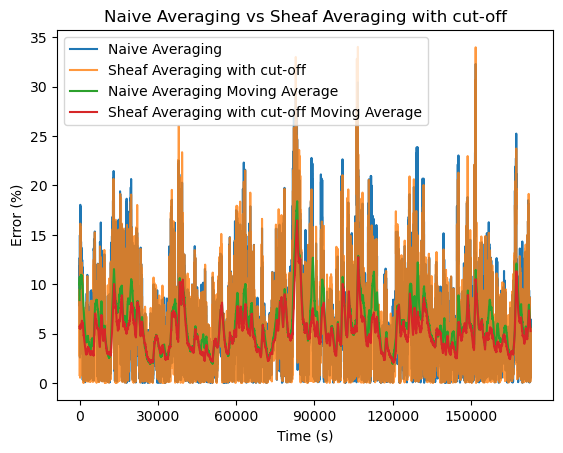

In [62]:
plt.plot(np.array(error_mean)*100, label="Naive Averaging")
plt.plot(np.array(error)*100, label="Sheaf Averaging with cut-off", alpha=0.8)
counter = 0
average = 0
FACTOR = 60
avg = []
for value in error_mean:
    counter += 1
    average = average + (value - average) / min(counter, FACTOR)
    avg.append(average)
plt.plot(np.array(avg)*100, label="Naive Averaging Moving Average")
avg = []
for value in error:
    counter += 1
    average = average + (value - average) / min(counter, FACTOR)
    avg.append(average)
plt.plot(np.array(avg)*100, label="Sheaf Averaging with cut-off Moving Average")
plt.xticks([0,2000,4000,6000,8000,10000],[list(filtration.keys())[index] for index in [0,2000,4000,6000,8000,10000]])
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Error (%)")
plt.title("Naive Averaging vs Sheaf Averaging with cut-off")
plt.show()

In [10]:
print(f"Error of the sheaf {np.mean(error)*100}%")
print(f"Error of the sensor values average {np.mean(error_mean)*100}%")
print(f"Error of the sensor S1 {np.mean(error_s1)*100}%")
print(f"Error of the sensor S2 {np.mean(error_s2)*100}%")
print(f"Error of the sensor C1 {np.mean(error_c1)*100}%")
print(f"Error of the sensor C2 {np.mean(error_c2)*100}%")

Error of the sheaf 5.1888896147178105%
Error of the sensor values average 5.9252562896393455%
Error of the sensor S1 2.8283811217361245%
Error of the sensor S2 8.253305812925788%
Error of the sensor C1 11.73873601807465%
Error of the sensor C2 16.932767395608675%


In [11]:
print(f"Error of the sheaf is {np.abs(np.mean(error) - np.mean(error_mean))*100 / np.mean(error_mean)}% better than purely averaging")

Error of the sheaf is 12.427591971154305% better than purely averaging


# Example 3

Analyze the minute #1545.5, where the data spread measured by the consistency filtration peaks, in details to show the effect of cutting off nodes with large consistency thresholds.

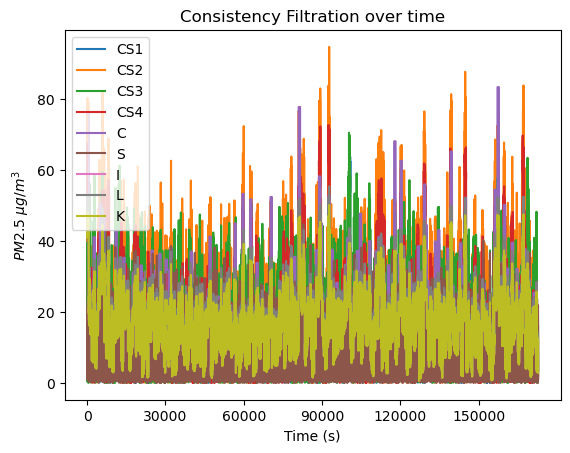

In [63]:
faces = ["CS1", "CS2", "CS3", "CS4", "C", "S", "I", "L", "K"]
faces_pos = {}
for face in faces:
    faces_pos[face] = []

for i in filtration:
    for face in faces:
        faces_pos[face].append(filtration[i][face])
        
for face in faces:
    plt.plot(np.arange(0,11520,1),faces_pos[face][:11520],label=face)

plt.xticks([0,2000,4000,6000,8000,10000],[list(filtration.keys())[index] for index in [0,2000,4000,6000,8000,10000]])
l = r'PM2.5\ \mu g/m^3'
plt.ylabel("$%s$" %l)
plt.xlabel("Time (s)")
plt.legend()
plt.title("Consistency Filtration over time")
plt.show()

In general, the consistency filtration over time is aligned with the errors initiated for each sensor: most of the time the face CS2, CS4 and C are the most erroneous; and this is corresponding to the two most inaccurate nodes, such as C1 and C2.

In [13]:
print(f"The spread of data consistency threshold peaks at time {max_pos}s ~ {max_pos/60} min with the following filtration")
print(filtration[max_pos])

The spread of data consistency threshold peaks at time 92730s ~ 1545.5 min with the following filtration
{'CS1': 8.283882338353894, 'S': 33.620082580239966, 'CS3': 41.903964918593864, 'K': 50.105373654118516, 'I': 51.284484945400095, 'C': 52.72299262385046, 'L': 55.393574797089926, 'CS4': 61.00687496220436, 'CS2': 94.62695754244432}


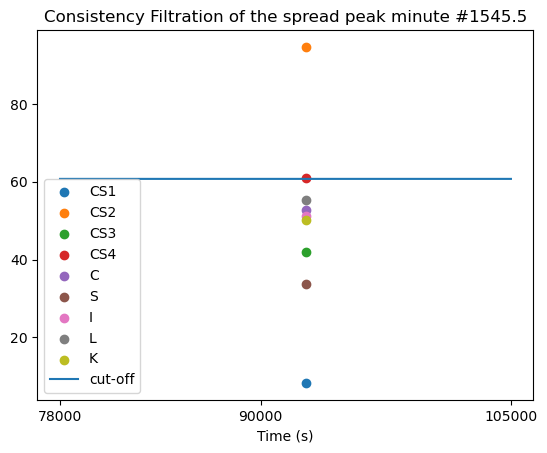

In [14]:
for face in faces:
    plt.scatter(list(filtration.keys()).index(max_pos),faces_pos[face][list(filtration.keys()).index(max_pos)],label=face)

filt = [faces_pos[face][list(filtration.keys()).index(max_pos)] for face in faces]
cut_off = np.mean(filt) + 0.5*np.std(filt)
plt.plot(np.arange(5200,7000),[cut_off]*(7000-5200), label="cut-off")
plt.xlabel("Time (s)")
plt.legend()
plt.xticks([5200,6000,7000],[list(filtration.keys())[index] for index in [5200,6000,7000]])
plt.title("Consistency Filtration of the spread peak minute #1545.5")
plt.show()

In [15]:
value_list = []
for i in range(len(filtration[max_pos])):
    value_list.append(np.mean(values[max_pos][list(filtration[max_pos].keys())[i]]))

value = np.mean(value_list)

value_list = []
for i in range(len(filtration[max_pos])):
    if list(filtration[max_pos].values())[i] <= np.mean(list(filtration[max_pos].values())) + 0.5*np.std(list(filtration[max_pos].values())):
        value_list.append(np.mean(values[max_pos][list(filtration[max_pos].keys())[i]]))

value_cutoff = np.mean(value_list)

print(f"The mean of the sheaf with cut-off = {value_cutoff}")
print(f"The mean of the sheaf without cut-off = {value}")
print(f"The naive average = {mean[max_pos]}")
print(f"The true value = {PM[max_pos]}")

The mean of the sheaf with cut-off = 193.7179488029373
The mean of the sheaf without cut-off = 199.0437753184763
The naive average = 199.04377531847626
The true value = 179.2788672677023


In [16]:
print(f"Error of the mean of the sheaf with cut-off to true value = {np.abs(value_cutoff-PM[max_pos])*100/PM[max_pos]}%")
print(f"Error of the mean of the sheaf without cut-off to true value = {np.abs(value-PM[max_pos])*100/PM[max_pos]}%")
print(f"Error of the naive average to true value = {np.abs(mean[max_pos]-PM[max_pos])*100/PM[max_pos]}%")

Error of the mean of the sheaf with cut-off to true value = 8.053978561608318%
Error of the mean of the sheaf without cut-off to true value = 11.024672540607188%
Error of the naive average to true value = 11.02467254060717%


By using the sheaf cut-off, sheaf consistency structure helps reduce ~3% error compared to using naive averaging aggregation method.